initial point: [-5.01 -5.01] f(x0) 90697.93230099998
BFGSMethod: x*: [0.99999987 0.99999973] f(x*): 4.7879470810341033e-14 iterations: 94


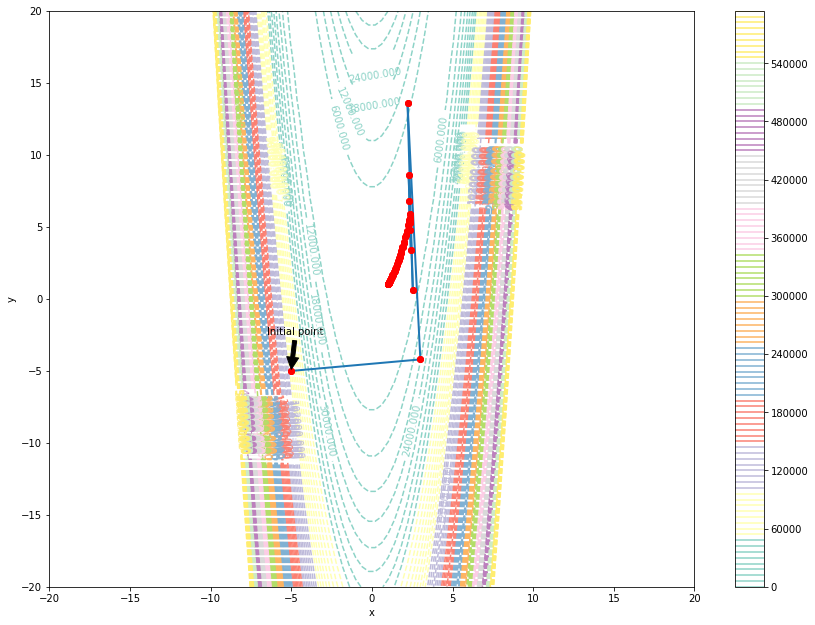

In [4]:
import numpy as np
import sympy as sym
from math import *
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from sympy import Function, hessian, pprint, Matrix, simplify

def calcGrad(expression, Symbols):
    grad = []
    for i in range (len(Symbols)):
        grad.append(sym.diff(expression,Symbols[i] ))
    return grad

# Below symbolic calculation of gradient is performed
x, y = sym.symbols('x y')
expr = 100* (y -x**2)**2 + (1-x)**2
grad = calcGrad(expr, np.array([x,y]))
hess_matrix = Matrix(hessian(expr, (x, y)))
inv_hess = hess_matrix.inv()
func_call = 0
grad_call = 0
f = sym.lambdify([x, y], expr, "numpy") 
g = sym.lambdify([x, y], grad, "numpy") 
h = sym.lambdify([x, y], hess_matrix, "numpy") 
b = sym.lambdify([x, y], inv_hess, "numpy") 
# end of symbolic calculation

#functions to calc function and gradient value presented
def evalFunc(args):
    global  func_call
    global f
    func_call+=1;
    return f(*args)

def evalGrad(args):
    global  grad_call
    global g
    grad_call+=1;
    return Matrix(g(*args))

def evalHess(args):
    return Matrix(h(*args))

def evalInvHess(args):
    return Matrix(b(*args))

def refineWolfAndAmiio(x0, step, direction, func_initial,slope):
    x_new = x0 + step* direction
    new_slope = direction.dot(evalGrad(x_new))
    c1 = 0.15
    if (step < eps): 
        print("exceed min step size", eps)
        return step
    if (evalFunc(x_new) > (func_initial+ c1* step * slope) or new_slope < slope):
        return refineWolfAndAmiio(x0, 0.9* step, direction, func_initial,slope)
    return step
def checkCurvCondition(x0,x1):
    s = np.array(x1 - x0)
    d = np.array(evalGrad(x1) - evalGrad(x0),  dtype=np.float64).flatten() 
#     print(s.dot( d))

def approxInvHesCalc(prev,x0,x1,dim):
    s = x1 - x0
    d = np.array(evalGrad(x1) - evalGrad(x0)).flatten()
    term_1 = (np.identity(dim) - np.outer(s,d)/(d@s)) * prev * (np.identity(dim) - np.outer(d,s)/(d@s))
    return term_1 + np.outer(s,s)/(d@s)

def pureNewtonMethod (x0):
    x1 = x0.copy()
    iterations = 0
    f_min_cur = 10e8
    array_to_plot = [[iterations,*x0, evalFunc(x0)]]
    while ((np.linalg.norm(x1-x0))>eps or iterations == 0):    
        x0 = x1.copy()
        direction = -np.array(evalInvHess(x0)* evalGrad(x0),dtype=np.float64).flatten()
        x1 = np.array(x0 + direction)
        f_min_prev = f_min_cur
        f_min_cur = evalFunc(x1)
        iterations+=1
        array_to_plot.append([iterations,*x0, f_min_cur ])
    return (x1,f_min_cur, iterations,array_to_plot)

def BFGSMethod (x0):
    iterations = 0
    f_min_prev = 1e20
    f_min_cur = evalFunc(x0)
    prev_hess = Matrix(np.identity(2))#evalHess(x0)
    inv_hess = Matrix(np.identity(2))
    direction = -np.array(inv_hess* evalGrad(x0),  dtype=np.float64).flatten()
    c2 = 0.9
    desired_slope = c2 * direction.dot(evalGrad(x0))
    step = refineWolfAndAmiio(x0,5.0, direction, evalFunc(x0),desired_slope)
    x1 = np.array(x0 + step * direction)
    array_to_plot = [[iterations,*x0, evalFunc(x0)]]
    while ((abs(f_min_cur - f_min_prev)>eps or np.linalg.norm(x1-x0)>eps) or iterations == 0):    
        inv_hess = approxInvHesCalc(inv_hess,x0,x1,2) #new_hess.inv()
        x0 = x1.copy()
        direction = -np.array(inv_hess.copy()* evalGrad(x0),  dtype=np.float64).flatten()
        desired_slope = c2 * direction.dot(evalGrad(x0))
        step = refineWolfAndAmiio(x0,5.0, direction, evalFunc(x0),desired_slope)
        x1 = x0 + step * direction
        checkCurvCondition(x0,x1)
        f_min_prev = f_min_cur
        f_min_cur = evalFunc(x1)
        iterations+=1
        array_to_plot.append([iterations,*x0, f_min_cur ])
    return (x1, f_min_cur, iterations,array_to_plot)

eps = 1e-6
x0 = np.array([-5.01,-5.01]) 
print ("initial point:",x0,"f(x0)", evalFunc(x0))
x1,f_min_cur, iterations,array_to_xls = pureNewtonMethod(x0.copy())
# print("pureNewtonMethod:", "x*:", x1,"f(x*):", f_min_cur,"iterations:", iterations)
# printPlot(array_to_xls)
x1,f_min_cur, iterations,array_to_xls = BFGSMethod(x0.copy())
print("BFGSMethod:", "x*:", x1,"f(x*):", f_min_cur,"iterations:", iterations)
printPlot(array_to_xls)

In [2]:
def printPlot(array):
    fig = plt.figure(figsize=(14,10))
    left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes([left, bottom, width, height]) 

    start, stop, n_values = -20,20, 100
    x_vals = np.linspace(start, stop, n_values)
    y_vals = np.linspace(start, stop, n_values)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = evalFunc([X,Y])

    cp = plt.contour(X, Y, Z,levels = np.arange(0, 600000, 6000), cmap = 'Set3', linestyles='dashed')
    plt.colorbar()
    plt.clabel(cp, inline=True, fontsize=10)
    plt.xlabel('x')
    plt.ylabel('y')
    # drawing dots
    for i in range (len(array)):
        plt.plot(array[i][1],array[i][2], 'ro')
    ax.annotate('Initial point', xy=(array[0][1],array[0][2]), 
                xytext=(array[0][1] -1.5 ,array[0][2] +2.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    #drawing lines
    lines = [] 
    for i in range (len(array)-1):
        plt.plot(array[i][1],array[i][2], 'ro')
        lines.append([(array[i][1],array[i][2]) ,(array[i+1][1],array[i+1][2])]) 
    lc = mc.LineCollection(lines, linewidths=2)
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.show()
    